# DCGAN — Bug-Fix Labs - 10 Bugs

In [ ]:
import torch, torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# ---------------------------
# Data
# ---------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # BUG: Add normalization to the RGB image ("No pre-processing was applied to training images besides scaling to the range of the tanh activation function [-1, 1]"")
])
ds = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform)
loader = DataLoader(ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

100%|██████████| 170M/170M [00:04<00:00, 41.2MB/s]


In [ ]:
# ---------------------------
# Hyperparams
# ---------------------------
z_dim = 100
g_lr  = 2e-4   # BUG: fix learning rate based
d_lr  = 2e-4

In [ ]:
# ---------------------------
# Models
# ---------------------------
class D(nn.Module):
    def __init__(self, ch=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, ch,   4, 2, 1),
            nn.BatchNorm2d(ch),
            nn.LeakyReLU(0.2,inplace=True),         # BUG (was ReLU) fix: we should use LeakyReLU as suggested by the paper
            nn.Conv2d(ch, ch*2, 4, 2, 1),
            nn.BatchNorm2d(ch*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ch*2, ch*4, 4, 2, 1),
            nn.BatchNorm2d(ch*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ch*4, 1,    4, 1, 0),
            #nn.Sigmoid()                   # BUG: since we are using BCE with logits outputs, we don't need to have sigmoid here since it is already used internally by the loss func
        )
    def forward(self, x):
        return self.net(x).view(x.size(0))

class G(nn.Module):
    def __init__(self, z=100, ch=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z,   ch*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ch*4), nn.ReLU(True),
            nn.ConvTranspose2d(ch*4, ch*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ch*2), nn.ReLU(True),
            nn.ConvTranspose2d(ch*2, ch,   4, 2, 1, bias=False),
            nn.BatchNorm2d(ch),   nn.ReLU(True),
            nn.ConvTranspose2d(ch,  3,     4, 2, 1, bias=False),
            # BUG: add tanh as an activation function in the end of the G
            nn.Tanh()
        )
    def forward(self, z):
        z = z.view(z.size(0), z_dim, 1, 1)   # BUG: the z_dim should be used here, instead of 64
        return self.net(z)

Dnet = D().to(device)
Gnet = G(z_dim).to(device)

In [ ]:
# ---------------------------
# Loss & Optimizers
# ---------------------------
crit = nn.BCEWithLogitsLoss()             # using logits loss → D must NOT have Sigmoid
opt_d = torch.optim.Adam(Dnet.parameters(), lr=d_lr, betas=(0.5, 0.999))
opt_g = torch.optim.Adam(Gnet.parameters(), lr=g_lr,  betas=(0.5, 0.999))

In [ ]:
# ---------------------------
# Training (intentionally wrong)
# ---------------------------
epochs = 20 # Define number of epochs for training
for epoch in range(epochs):
    for i, (real, _) in enumerate(loader):
        real = real.to(device)
        b = real.size(0)

        # ---- Discriminator step ----
        opt_d.zero_grad()                                # (missing) zero the gradients for D
        z = torch.randn(b, z_dim, device=device)
        fake = Gnet(z).detach()                         # BUG: apply detach to remove the gradient graph

        # BUG: fix the target labels by switching ones and zeros
        loss_d = crit(Dnet(real), torch.ones(b, device=device)) + \
                 crit(Dnet(fake), torch.zeros (b, device=device))

        loss_d.backward()
        opt_d.step()                           # BUG: replace opt_g with _d

        # ---- Generator step ----
        opt_g.zero_grad()                                # (missing) zero the gradients for G
        z = torch.randn(b, z_dim, device=device)
        fake = Gnet(z)

        loss_g = crit(Dnet(fake), torch.ones(b, device=device)) # BUG: G wants D to output 1 for fake images
        loss_g.backward()
        opt_g.step()

        # print error
        if i % 100 == 0: # Print every 100 batches
            print(f"Epoch [{epoch+1}/{epochs}] Batch [{i}/{len(loader)}] Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")


    # (missing) Add logging or visualization of generated images
    # (missing) Save model checkpoints

print("Your task: fix all 10 bugs until training runs and samples look reasonable.")

Epoch [1/20] Batch [0/391] Loss D: 0.4383, Loss G: 4.3423
Epoch [1/20] Batch [100/391] Loss D: 0.4601, Loss G: 4.1538
Epoch [1/20] Batch [200/391] Loss D: 0.2387, Loss G: 4.0395
Epoch [1/20] Batch [300/391] Loss D: 0.2665, Loss G: 4.2559
Epoch [2/20] Batch [0/391] Loss D: 0.3817, Loss G: 2.9869
Epoch [2/20] Batch [100/391] Loss D: 0.3787, Loss G: 2.2038
Epoch [2/20] Batch [200/391] Loss D: 0.3481, Loss G: 2.2987
Epoch [2/20] Batch [300/391] Loss D: 0.2562, Loss G: 4.0353
Epoch [3/20] Batch [0/391] Loss D: 5.5286, Loss G: 7.8756
Epoch [3/20] Batch [100/391] Loss D: 0.4367, Loss G: 2.4823
Epoch [3/20] Batch [200/391] Loss D: 0.4960, Loss G: 2.3239
Epoch [3/20] Batch [300/391] Loss D: 0.6724, Loss G: 2.3151
Epoch [4/20] Batch [0/391] Loss D: 0.5990, Loss G: 1.3251
Epoch [4/20] Batch [100/391] Loss D: 0.5253, Loss G: 2.3843
Epoch [4/20] Batch [200/391] Loss D: 0.4770, Loss G: 2.8376
Epoch [4/20] Batch [300/391] Loss D: 0.3318, Loss G: 2.4590
Epoch [5/20] Batch [0/391] Loss D: 0.6481, Loss 

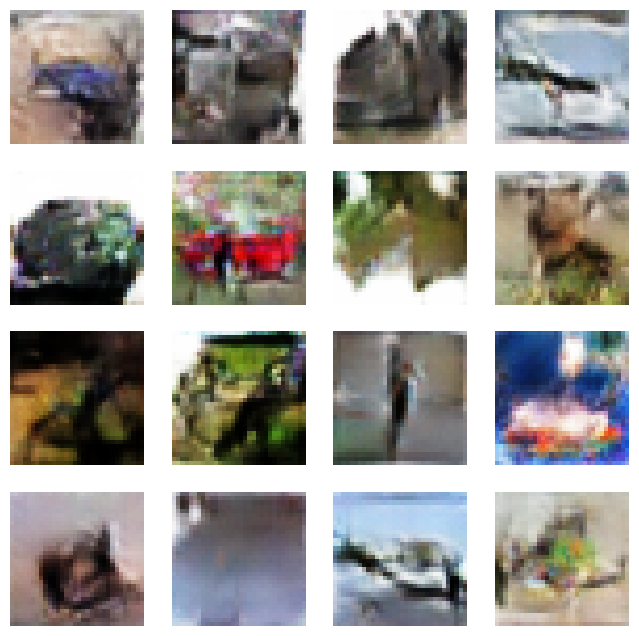

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some images
with torch.no_grad():
    z = torch.randn(16, z_dim, device=device) # Generate 16 images
    generated_images = Gnet(z).detach().cpu()

# Denormalize the images
generated_images = generated_images * 0.5 + 0.5

# Display the images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = np.transpose(generated_images[i].numpy(), (1, 2, 0))
    ax.imshow(img)
    ax.axis('off')
plt.show()